In [1]:
import numpy as np
import pyasdf
import matplotlib.pyplot as plt
import toml

In [2]:
def load_reference_data(filename):
    
    data = np.loadtxt(filename, skiprows=1, usecols=[1,2,3,4,5,6,7,8])
    lat = data[:,0]
    lon = data[:,1]
    east = data[:,2] * (90 - data[:,3]) / 90
    north = data[:,4] * (90 - data[:,5]) / 90
    vertical = data[:,6] * (90 - data[:,7]) / 90
    return {'lat': lat, 
            'lon': lon, 
            'east': east, 
            'north': north, 
            'vertical': vertical }


In [3]:
def load_data(hdf5_file):
    
    
    with pyasdf.ASDFDataSet(hdf5_file) as ds:
        
        numRec = len(ds.waveforms)  
        lat = np.zeros(numRec)
        lon = np.zeros(numRec)
        east = np.zeros(numRec)
        north = np.zeros(numRec)
        vertical = np.zeros(numRec)
        
        i=0
        for station in ds.waveforms:

            lat[i] = station.coordinates['latitude']
            lon[i] = station.coordinates['longitude']            
            north[i] = station.displacement.select(component='N')[0].data[1]
            east[i] = station.displacement.select(component='E')[0].data[1]
            vertical[i] = station.displacement.select(component='Z')[0].data[1]        
            i=i+1
    
    return {'lat': lat, 
            'lon': lon, 
            'east': east, 
            'north': north, 
            'vertical': vertical }


In [4]:
def create_benchmark_figure(title, 
                            filename_reference_data,
                            benchmark_data,
                            gravitational_acceleration,
                            freshwater_density=1000.0,
                            output_filename=None):

    # scale Salvus output and convert it into mm
    scale = gravitational_acceleration * freshwater_density * 1000.0
    
    ref_data =  load_reference_data(filename_reference_data)
    data = {}
    for key in benchmark_data:
        print('process data for',key )
        data[key] = load_data(benchmark_data[key]['hdf5-file'])
        
    plt.figure(1, figsize=(8,6))
    plt.subplot(311)
    for key in data:
        plt.plot(data[key]['lat'], scale * data[key]['east'], label=key)
    plt.plot(ref_data['lat'], ref_data['east'], 'k--', label='reference')
    plt.grid(True)
    plt.title('East | {0} | npole-and-spole'.format(title))
    plt.ylabel('disp (mm)')
    plt.xlim(-90,90)
    plt.ylim(-0.05,0.05)

    plt.subplot(312)
    for key in data:
        plt.plot(data[key]['lat'], scale * data[key]['north'], label=key)
    plt.plot(ref_data['lat'], ref_data['north'], 'k--', label='reference')
    plt.grid(True)
    plt.title('North | {0} | npole-and-spole'.format(title))
    plt.ylabel('disp (mm)')
    plt.xlim(-90,90)

    plt.subplot(313)
    for key in data:
        plt.plot(data[key]['lat'], scale * data[key]['vertical'], label=key)       
    plt.plot(ref_data['lat'], ref_data['vertical'], 'k--', label='reference')
    plt.grid(True)
    plt.title('Vertical | {0} | npole-and-spole'.format(title))
    plt.xlabel('latitude (degrees)')
    plt.ylabel('disp (mm)')
    plt.xlim(-90,90)
    plt.legend()
    plt.tight_layout()
    
    if output_filename is not None:
        plt.savefig(output_filename)


process data for 100s-p1


/home/hm882590e/anaconda3/envs/salvus/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


process data for 100s-p2
process data for 100s-p4


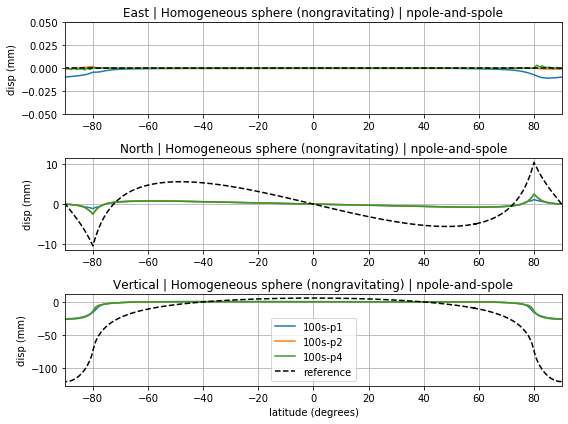

In [5]:
G = 6.67408e-11
R = 6371000.0
rho = 3000.0
grav_acc = rho * G * 4/3 * np.pi * R 

create_benchmark_figure('Homogeneous sphere (nongravitating)', 
                        '../benchmark/10degCaps_noTaper_Homogeneous_Vp05.92_Vs03.42_Rho03.00_analytical_noDeg1_dens1000_nonGravitating.txt',
                        {
                            '100s-p1' : {
                                'toml-file': 'homogeneous-100s-p1-wTide/receivers.toml',
                                'hdf5-file': 'homogeneous-100s-p1-wTide/receiver.h5'
                            },                            
                            '100s-p2' : {
                                'toml-file': 'homogeneous-100s-p2-wTide/receivers.toml',
                                'hdf5-file': 'homogeneous-100s-p2-wTide/receiver.h5'
                            },
                            '100s-p4' : {
                                'toml-file': 'homogeneous-100s-p4-wTide/receivers.toml',
                                'hdf5-file': 'homogeneous-100s-p4-wTide/receiver.h5'
                            },                            
                        },
                        grav_acc)